## Starter Notebook For The Côte d’Ivoire Byte-Sized Agriculture Challenge

This starter notebook achieves the following:


1.   Load & display satellite images
2.   Build a basic machine learning model
3.   Prepare the predictions for submission.

The machine learning model shown here is by no mean ideal. Winning models should leverage multi-temporal data and not single-date imagery.

# Processing  the GTIFF files

Here's a complete list of **Sentinel-2 bands** along with their **descriptions**, **wavelengths**, and **spatial resolutions**:

---

### 🛰️ **Sentinel-2 Band Overview**

| Band | Name                    | Wavelength (nm) | Resolution (m) | Description |
|------|-------------------------|-----------------|----------------|-------------|
| B1   | Coastal aerosol         | 443             | 60             | Useful for atmospheric correction and aerosol detection. |
| B2   | Blue                    | 490             | 10             | Penetrates water; used for vegetation, water bodies, and coastal mapping. |
| B3   | Green                   | 560             | 10             | Good for assessing plant health and measuring biomass. |
| B4   | Red                     | 665             | 10             | Key band for vegetation discrimination and chlorophyll absorption. |
| B5   | Red Edge 1              | 705             | 20             | Useful for detecting subtle changes in vegetation. |
| B6   | Red Edge 2              | 740             | 20             | Further detail on vegetation, especially stress and growth stages. |
| B7   | Red Edge 3              | 783             | 20             | Extended vegetation monitoring. |
| B8   | NIR (Near Infrared)     | 842             | 10             | Excellent for vegetation vigor, biomass, and land-water contrast. |
| B8A  | Narrow NIR (Red Edge 4) | 865             | 20             | Sensitive to chlorophyll content and canopy structure. |
| B9   | Water Vapor             | 945             | 60             | Atmospheric correction (water vapor absorption). |
| B10  | SWIR – Cirrus           | 1375            | 60             | Detects high-altitude clouds (cirrus); not used for land analysis. |
| B11  | SWIR 1                  | 1610            | 20             | Differentiates clouds, snow, and vegetation moisture. |
| B12  | SWIR 2                  | 2190            | 20             | Useful for geology, soil, and burnt area mapping. |

---

### ✅ Band Groupings by Application

#### **RGB (Natural Color)**
- **B4 (Red)**
- **B3 (Green)**
- **B2 (Blue)**

#### **Vegetation Indices**
- **NDVI:** B8 (NIR) & B4 (Red)
- **EVI:** B8 (NIR), B4 (Red), B2 (Blue)
- **SAVI:** B8 (NIR) & B4 (Red)
- **NDRE:** B8A (Narrow NIR) & B5 (Red Edge)

#### **Cloud/Atmosphere Analysis**
- B1, B9, B10

#### **Snow/Ice Monitoring**
- B3, B11, B12

---


In [1]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install rasterio -q

In [3]:
import os
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import gc

In [4]:
DATA_PATH = Path("/content/drive/MyDrive/")
TRAIN_IMAGES_PATH = DATA_PATH / "train_s2_images_new_final"
TEST_IMAGES_PATH = DATA_PATH / "test_s2_images_new_final_"
TRAIN_CSV_PATH = "TrainDataset.csv"
TEST_CSV_PATH = "TestDataset.csv"
subPath = "submission.csv"

In [5]:
## Utility function - count the number of files in a folder:

def count_all_files(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [6]:
folder_path = TRAIN_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in '/content/drive/MyDrive/train_s2_images_new_final': 7433


In [7]:
folder_path = TEST_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in '/content/drive/MyDrive/test_s2_images_new_final_': 2201


In [8]:
## Load the train/test csv files
train = pd.read_csv(TRAIN_CSV_PATH)
test = pd.read_csv(TEST_CSV_PATH)

In [9]:
train.head()

ID  year month  \
0  ID_h14T0B_Jan  2024   Jan   
1  ID_KbyKOr_Jan  2024   Jan   
2  ID_t4Tmmn_Jan  2024   Jan   
3  ID_yipWoC_Jan  2024   Jan   
4  ID_XKiksa_Jan  2024   Jan   

                                             tifPath  Target  class  
0  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
1  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
2  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
3  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
4  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3

In [10]:
test.head()

ID  year month  \
0  ID_731818_Jan  2024   Jan   
1  ID_790093_Jan  2024   Jan   
2  ID_931033_Jan  2024   Jan   
3  ID_079024_Jan  2024   Jan   
4  ID_691532_Jan  2024   Jan   

                                             tifPath  
0  /content/drive/MyDrive/test_s2_images_new_fina...  
1  /content/drive/MyDrive/test_s2_images_new_fina...  
2  /content/drive/MyDrive/test_s2_images_new_fina...  
3  /content/drive/MyDrive/test_s2_images_new_fina...  
4  /content/drive/MyDrive/test_s2_images_new_fina...

In [11]:
train_tiffs = [Path(tifPath) for tifPath in train.tifPath.values if str(tifPath).endswith(".tif")]
len(train_tiffs)

7433

In [12]:
test_tiffs = [Path(tifPath) for tifPath in test.tifPath.values if str(tifPath).endswith(".tif")]
len(test_tiffs)

2201

In [13]:
## Check the size of each of these tifs

def print_tif_sizes(tif_files):
    """
    Prints the size of each TIFF file in MB and GB.

    Parameters:
        tif_files (list): List of TIFF file names (str).
    """
    for file_path in tif_files:

        # Get the size in bytes
        tif_size_bytes = os.path.getsize(file_path)

        # Convert bytes to MB and GB
        tif_size_kb = tif_size_bytes / 1024
        tif_size_mb = tif_size_bytes / (1024 * 1024)
        tif_size_gb = tif_size_bytes / (1024 * 1024 * 1024)

        # Print sizes
        print(f"{file_path.name} size: {tif_size_kb:.2f} KB")
        #print(f"{file_path.name} size: {tif_size_mb:.2f} MB")
        #print(f"{file_path.name} size: {tif_size_gb:.2f} GB")

In [14]:
## Check size of train files
print_tif_sizes(train_tiffs[:10])

s2_Rubber_ID_h14T0B_2024_01.tif size: 53.27 KB
s2_Rubber_ID_KbyKOr_2024_01.tif size: 54.37 KB
s2_Rubber_ID_t4Tmmn_2024_01.tif size: 56.38 KB
s2_Rubber_ID_yipWoC_2024_01.tif size: 55.25 KB
s2_Rubber_ID_XKiksa_2024_01.tif size: 56.55 KB
s2_Rubber_ID_zNx6qQ_2024_01.tif size: 54.95 KB
s2_Palm_ID_KfCbOO_2024_01.tif size: 97.40 KB
s2_Palm_ID_ZUfp59_2024_01.tif size: 59.64 KB
s2_Palm_ID_DdAycp_2024_01.tif size: 60.75 KB
s2_Rubber_ID_X9dg4u_2024_01.tif size: 54.03 KB


In [15]:
## Check size of test files
print_tif_sizes(test_tiffs[:10])

s2_Unknown_ID_731818_2024_01.tif size: 62.65 KB
s2_Unknown_ID_790093_2024_01.tif size: 61.45 KB
s2_Unknown_ID_931033_2024_01.tif size: 61.45 KB
s2_Unknown_ID_079024_2024_01.tif size: 61.45 KB
s2_Unknown_ID_691532_2024_01.tif size: 61.45 KB
s2_Unknown_ID_094903_2024_01.tif size: 61.45 KB
s2_Unknown_ID_601980_2024_01.tif size: 61.45 KB
s2_Unknown_ID_766365_2024_01.tif size: 61.45 KB
s2_Unknown_ID_406501_2024_01.tif size: 61.45 KB
s2_Unknown_ID_237616_2024_01.tif size: 62.65 KB


In [16]:
import rasterio

def get_tif_metadata(tif_path):
    """
    Retrieves and prints metadata for a given TIFF file.

    Parameters:
    - tif_path (str or Path): Path to the TIFF file.

    This function opens the TIFF file, retrieves its dimensions (width, height),
    and the number of bands, then prints the relevant metadata.
    """
    with rasterio.open(tif_path) as src:
        # Get the image width (number of columns)
        width = src.width

        # Get the image height (number of rows)
        height = src.height

        # Get the number of bands in the image (e.g., RGB bands or multispectral bands)
        count = src.count

        # Print image dimensions (width x height) and the number of bands
        print(f"Image Name: {tif_path.name}")
        print(f"Image Dimensions: {width}x{height} pixels")
        print(f"Number of Bands: {count}\n")


## Get Metadata Information

In [17]:
## Get meta data information for each train tiff
for train_tif in train_tiffs[:10]:
  get_tif_metadata(train_tif)

Image Name: s2_Rubber_ID_h14T0B_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_KbyKOr_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_t4Tmmn_2024_01.tif
Image Dimensions: 52x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_yipWoC_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_XKiksa_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_zNx6qQ_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_KfCbOO_2024_01.tif
Image Dimensions: 71x59 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_ZUfp59_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_DdAycp_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_X9dg4u_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12



In [18]:
## Get meta data for test tiffs
for test_tif in test_tiffs[:10]:
  get_tif_metadata(test_tif)

Image Name: s2_Unknown_ID_731818_2024_01.tif
Image Dimensions: 51x52 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_790093_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_931033_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_079024_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_691532_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_094903_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_601980_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_766365_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_406501_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_237616_2024_01.tif
Image Dimensions: 51x52 pixels
Number of Bands: 12



In [19]:
def get_min_max_tile_size(tif_paths):
    """
    Calculate both the minimum and maximum tile sizes (height × width) from a list of .tif file paths.

    Parameters:
    - tif_paths (list of str or Path): List of paths to .tif files

    Returns:
    - min_result (tuple): (min_size, shape, file_path, index)
    - max_result (tuple): (max_size, shape, file_path, index)
    """
    min_size = float('inf')
    max_size = 0
    min_shape = max_shape = (0, 0)
    min_file = max_file = None
    min_idx = max_idx = None

    for idx, path in enumerate(tif_paths):
        with rasterio.open(path) as src:
            height, width = src.height, src.width
            size = height * width

            if size < min_size:
                min_size = size
                min_shape = (height, width)
                min_file = path
                min_idx = idx

            if size > max_size:
                max_size = size
                max_shape = (height, width)
                max_file = path
                max_idx = idx

    min_result = (min_size, min_shape, str(min_file), min_idx)
    max_result = (max_size, max_shape, str(max_file), max_idx)
    return min_result, max_result

In [20]:
# Get min/max tile size of train
min_train_results, max_train_results = get_min_max_tile_size(train_tiffs)

# Get min/max tile size of test
min_test_results, max_test_results = get_min_max_tile_size(test_tiffs)

# Overall max_tile_size
max_tile_height = max(max_train_results[1][0], max_test_results[1][0])
max_tile_width = max(max_train_results[1][1], max_test_results[1][1])

# Assume a square tile
MAX_TILE_SIZE = max(max_tile_height, max_tile_width)

max_train_idx = max_train_results[3]
max_test_idx = max_test_results[3]

min_train_idx = min_train_results[3]
min_test_idx = min_test_results[3]

max_train_tif_shape = max_train_results[1]
max_test_tif_shape = max_test_results[1]

min_train_tif_shape = min_train_results[1]
min_test_tif_shape = min_test_results[1]

max_train_tif_file = max_train_results[2]
min_train_tif_file = min_train_results[2]

max_test_tif_file = max_test_results[2]
min_test_tif_file = min_test_results[2]

In [21]:
print(f"The maximum tile size for train is at {max_train_idx} with: (height x width) = {max_train_tif_shape}.")
print(f"The raster image from train with maximum dimension is:\n\t{max_train_tif_file}.\n")
print(f"The minimum tile size for train is at {min_train_idx}: (height x width) = {min_train_tif_shape}.")
print(f"The raster image from train with the minimum dimension is:\n\t{min_train_tif_file}.\n")

print(f"The maximum tile size for test is at {max_test_idx} with : (height x width) = {max_test_tif_shape}.")
print(f"The raster image from test with maximum dimension is:\n\t{max_test_tif_file}.\n")
print(f"The minimum tile size for test is at {min_test_idx}: (height x width) = {min_test_tif_shape}.")
print(f"The raster image from test with the minimum dimension is:\n\t{min_test_tif_file}.")

print(f"\nThe maximum tile size to use: MAX_TILE_SIZE = {(MAX_TILE_SIZE, MAX_TILE_SIZE)}.")

The maximum tile size for train is at 552 with: (height x width) = (236, 237).
The raster image from train with maximum dimension is:
	/content/drive/MyDrive/train_s2_images_new_final/s2_Cocoa_ID_MVbwcd_2024_01.tif.

The minimum tile size for train is at 0: (height x width) = (51, 51).
The raster image from train with the minimum dimension is:
	/content/drive/MyDrive/train_s2_images_new_final/s2_Rubber_ID_h14T0B_2024_01.tif.

The maximum tile size for test is at 192 with : (height x width) = (245, 326).
The raster image from test with maximum dimension is:
	/content/drive/MyDrive/test_s2_images_new_final_/s2_Unknown_ID_615930_2024_01.tif.

The minimum tile size for test is at 1: (height x width) = (51, 51).
The raster image from test with the minimum dimension is:
	/content/drive/MyDrive/test_s2_images_new_final_/s2_Unknown_ID_790093_2024_01.tif.

The maximum tile size to use: MAX_TILE_SIZE = (326, 326).


## Visualisation Functions

In [22]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window

## These functions assumes that the 6 bands downloaded are
## ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


def process_window(tif_path, window=None):
    """
    Reads a window or full data from a GeoTIFF and handles NoData values.
    """
    with rasterio.open(tif_path) as src:
        if window is not None:
            data = src.read(window=window)
        else:
            data = src.read()

        nodata_value = src.nodata
        if nodata_value is not None:
            data = np.ma.masked_equal(data, nodata_value)

    return data

def normalize_band(band):
    """
    Normalizes a band to the [0, 1] range, safely handling NaN/masked values.
    """
    band = np.ma.masked_invalid(band)
    band_min = band.min()
    band_max = band.max()

    if band_max > band_min:
        return (band - band_min) / (band_max - band_min)
    else:
        return band  # Return unchanged if no variation

## ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

def plot_rgb_window(tif_path, window=None, r_band_idx=3, g_band_idx=2, b_band_idx=1):
    """
    Plots an RGB composite image from the specified bands.
    """
    data = process_window(tif_path, window)

    red = normalize_band(data[r_band_idx, :, :])
    green = normalize_band(data[g_band_idx, :, :])
    blue = normalize_band(data[b_band_idx, :, :])

    rgb = np.stack([red, green, blue], axis=-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title(f"RGB Composite")
    plt.axis("off")
    plt.show()

def plot_single_band(tif_path, window=None, band_idx=0, cmap='gray'):
    """
    Plots a single band from the GeoTIFF.
    """
    data = process_window(tif_path, window)
    band_normalized = normalize_band(data[band_idx, :, :])

    plt.figure(figsize=(8, 8))
    plt.imshow(band_normalized, cmap=cmap)
    plt.title(f"Band {band_idx}")
    plt.axis("off")
    plt.show()

def plot_vegetation_index(tif_path, window=None, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn'):
    """
    Plots NDVI using the given Red and NIR band indices.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]
    ndvi = (nir - red) / (nir + red)

    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi, cmap=cmap)
    plt.title(f"Vegetation Index (NDVI)")
    plt.axis("off")
    plt.show()

def plot_evi(tif_path, window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral'):
    """
    Plots EVI using Red, Blue, and NIR band indices.
    Alternative cmaps 'coolwarm', 'PiYG', 'viridis'
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    blue = data[blue_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    L = 10000

    evi = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + L))

    plt.figure(figsize=(8, 8))
    plt.imshow(evi, cmap=cmap)
    plt.title(f"Enhanced Vegetation Index (EVI) - Window: {window}")
    plt.axis("off")
    plt.show()


def plot_savi(tif_path, window=None, red_band_idx=3, nir_band_idx=7, L=0.5, cmap='YlGn'):
    """
    Plots SAVI using Red and NIR bands with a soil brightness correction factor.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    savi = ((nir - red) / (nir + red + L)) * (1 + L)

    plt.figure(figsize=(8, 8))
    plt.imshow(savi, cmap=cmap)
    plt.title(f"Soil Adjusted Vegetation Index (SAVI)")
    plt.axis("off")
    plt.show()


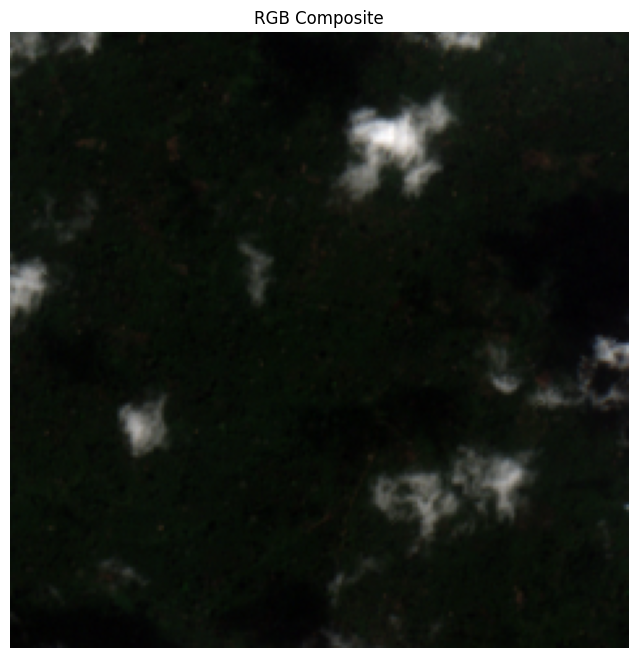

In [23]:
window = None #Window(0, 0, 1024, 1024)
# Plot RGB image (Red: band 2, Green: band 1, Blue: band 0)
plot_rgb_window(train_tiffs[max_train_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

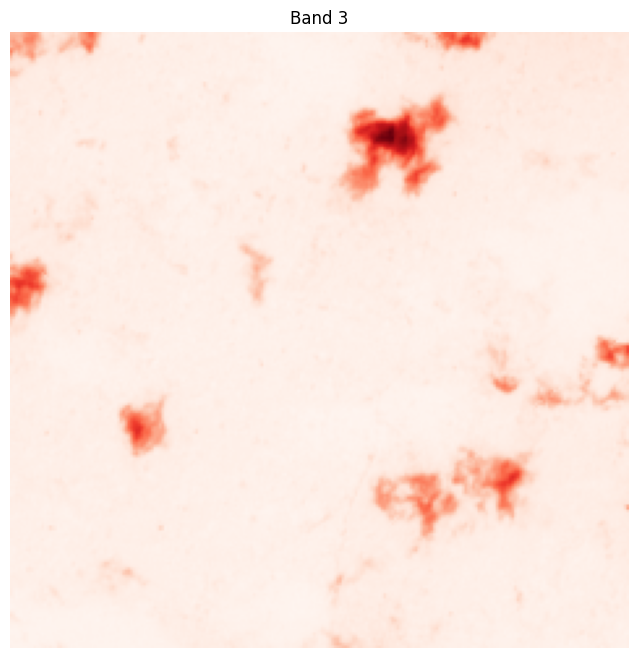

In [24]:
# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=3, cmap='Reds')

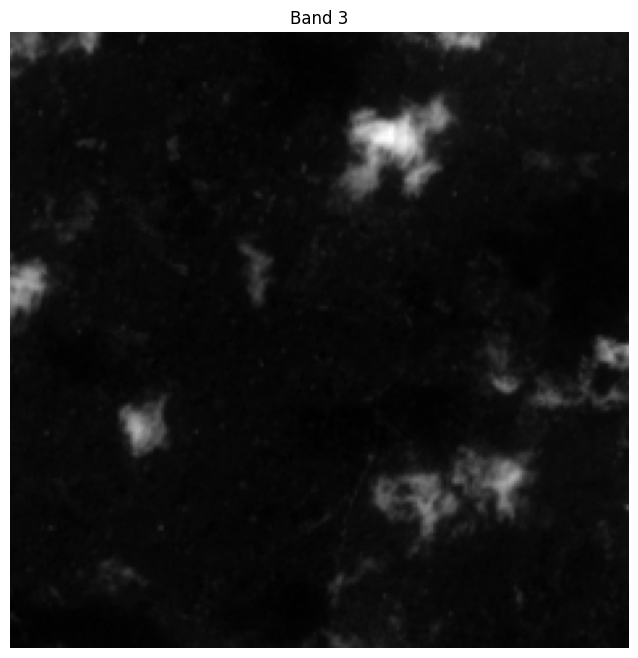

In [25]:
# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=3, cmap='gray')

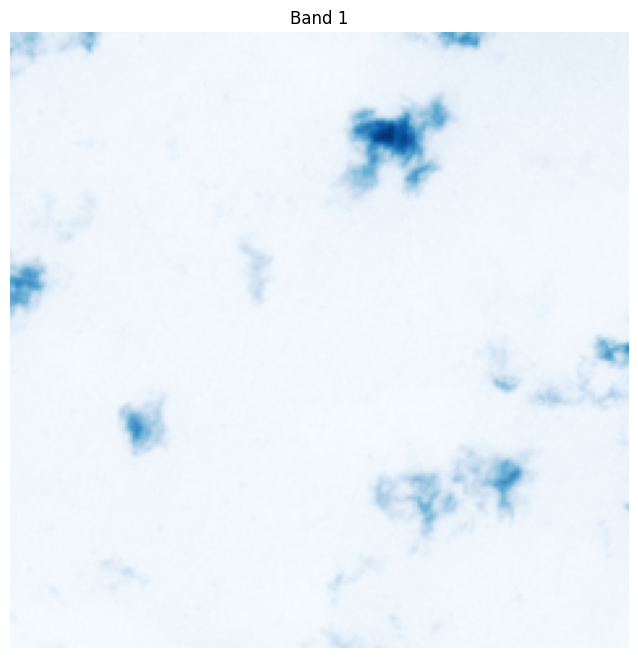

In [26]:
# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=1, cmap='Blues')

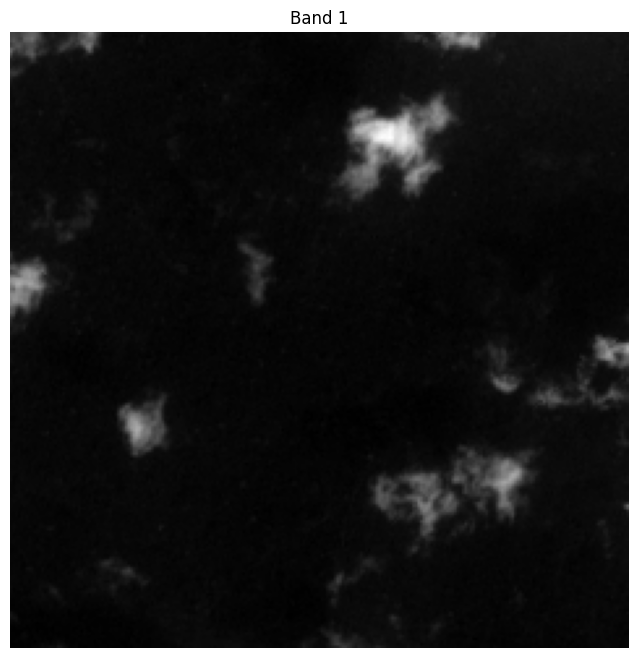

In [27]:
# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=1, cmap='gray')

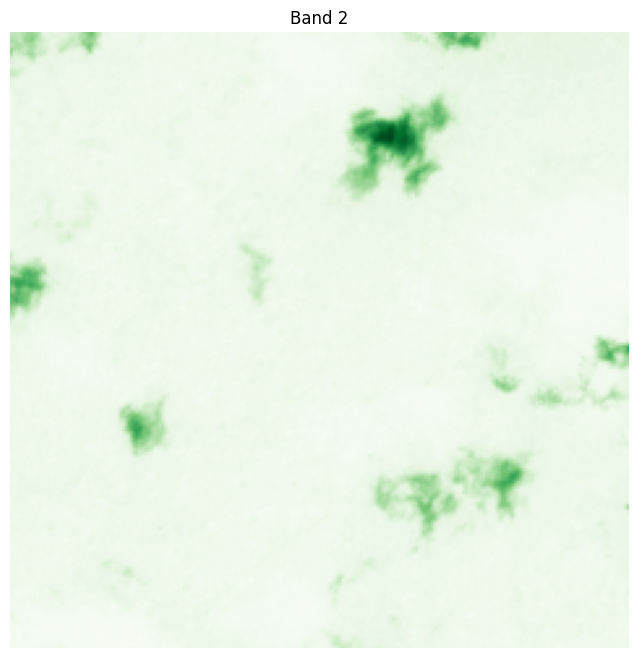

In [28]:
# Plot a single band (e.g., Green band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=2, cmap='Greens')

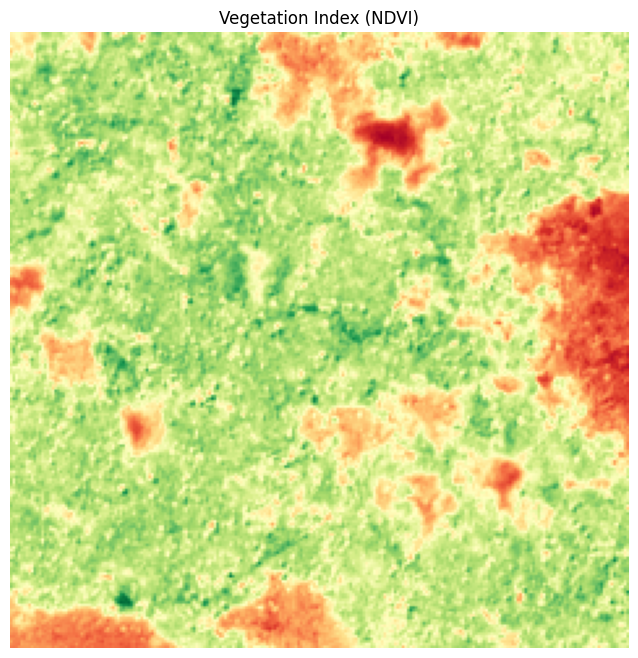

In [29]:
# Plot Vegetation Index (NDVI)
# cmap: 'viridis', 'BrBG', 'YlGn', 'PiYG', 'RdYlGn'
plot_vegetation_index(train_tiffs[max_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

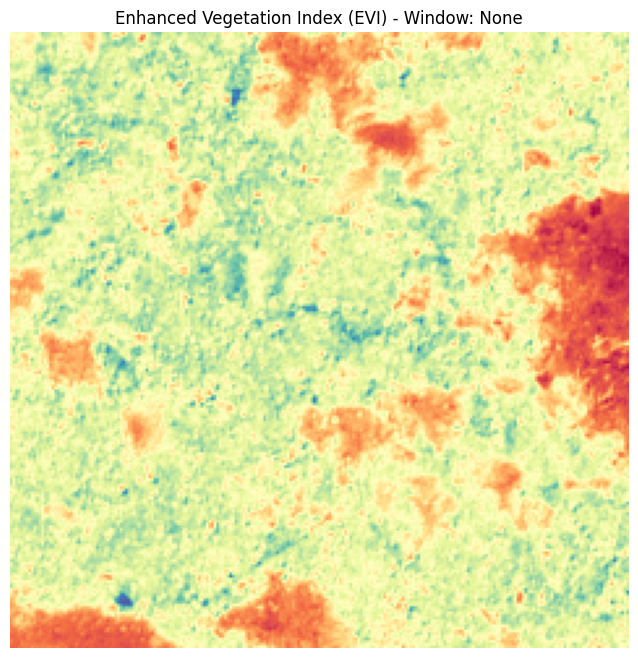

In [30]:
# Plot Enhanced Vegetation Index (EVI)
# cmap: 'coolwarm', 'PiYG', 'viridis', 'Spectral'
plot_evi(train_tiffs[max_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

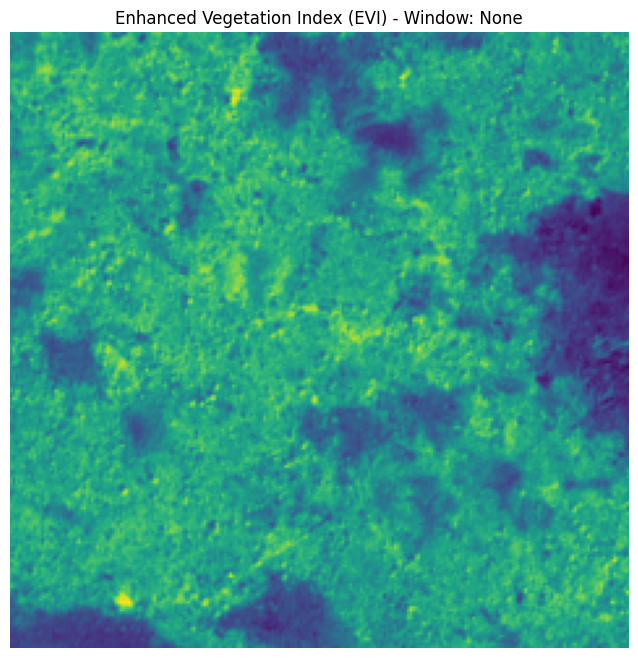

In [31]:
plot_evi(train_tiffs[max_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='viridis')

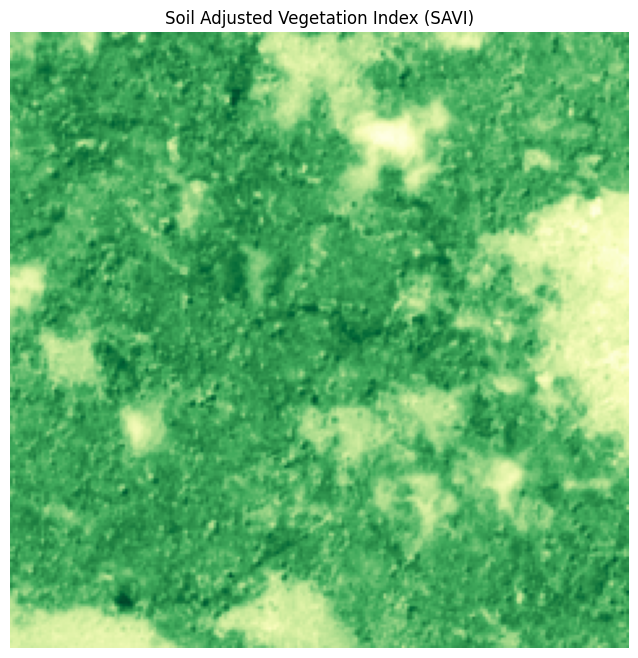

In [32]:
# Plot Soil Adjusted Vegetation Index (SAVI)
# cmap 'Greens', 'YlGnBu', 'YlGn'
plot_savi(train_tiffs[max_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

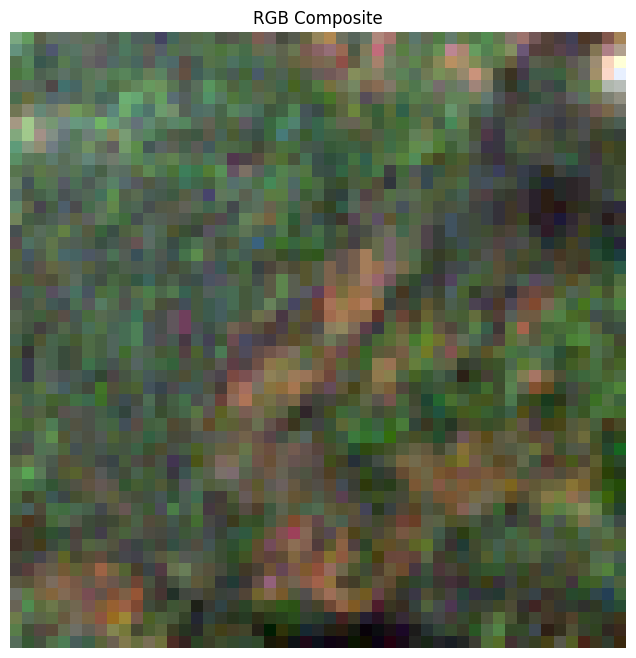

In [33]:
# Plot RGB image (Red: band 2, Green: band 1, Blue: band 0)
plot_rgb_window(train_tiffs[min_train_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

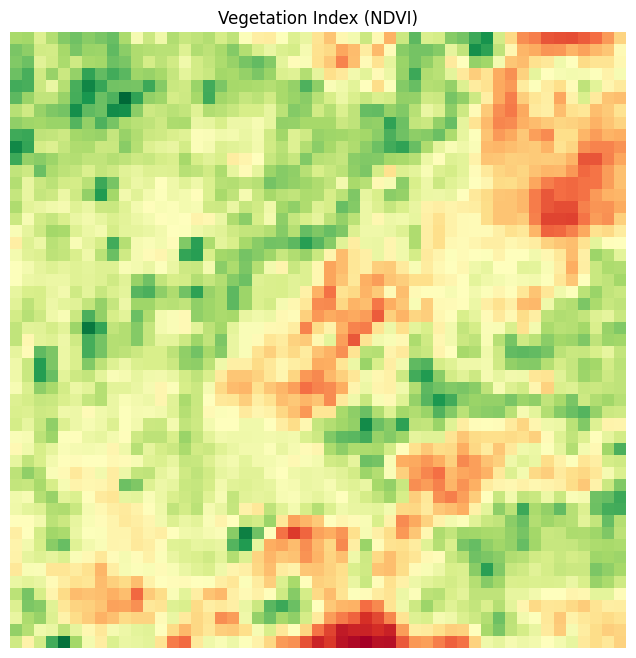

In [34]:
# Plot Vegetation Index (NDVI)
# cmap: 'viridis', 'BrBG', 'YlGn', 'PiYG', 'RdYlGn'
plot_vegetation_index(train_tiffs[min_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

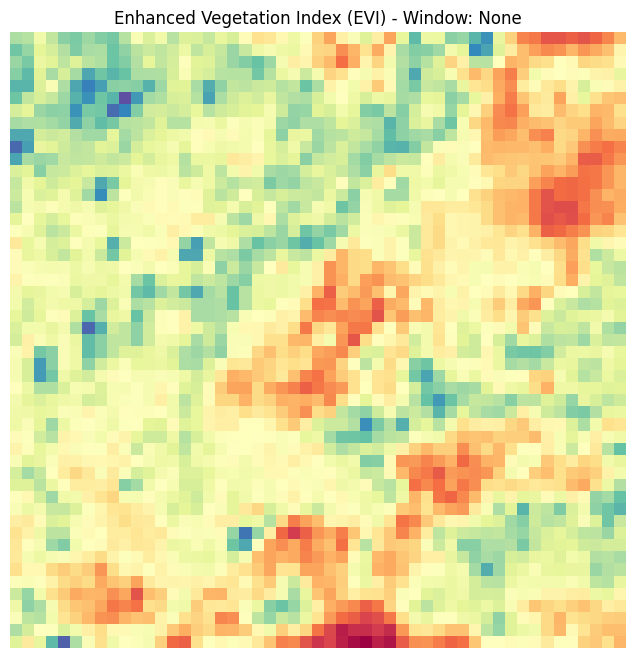

In [35]:
# Plot Enhanced Vegetation Index (EVI)
# cmap: 'coolwarm', 'PiYG', 'viridis', 'Spectral'
plot_evi(train_tiffs[min_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

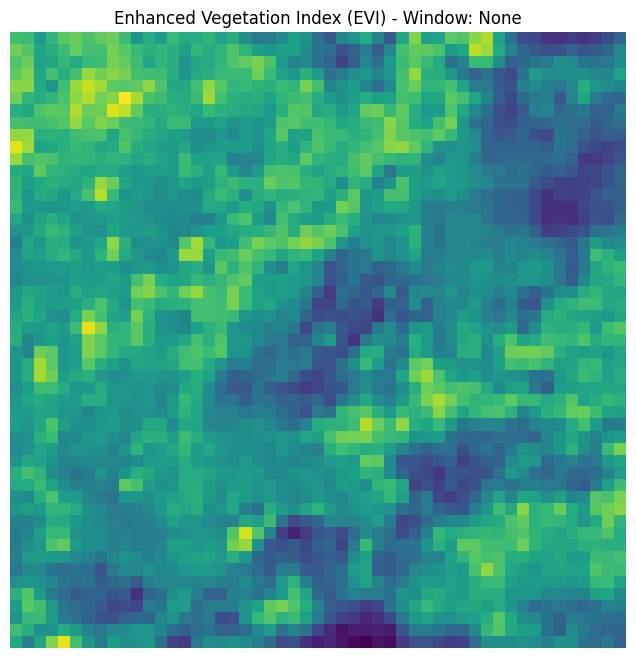

In [36]:
plot_evi(train_tiffs[min_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='viridis')

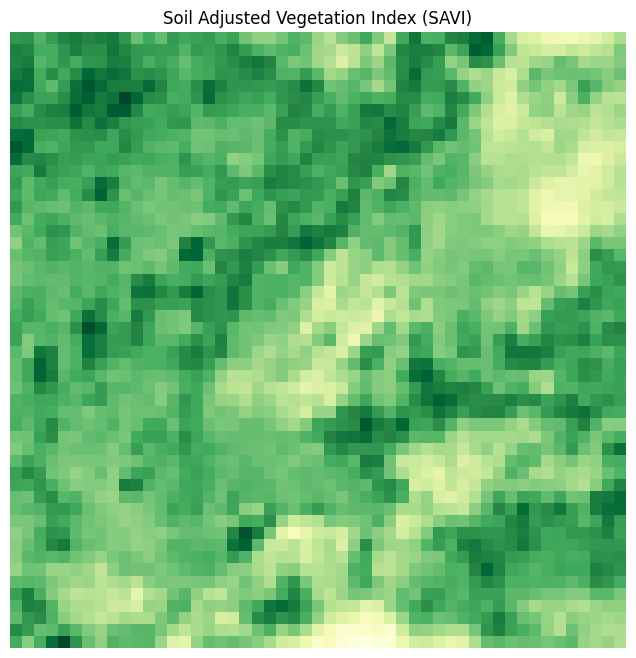

In [37]:
# Plot Soil Adjusted Vegetation Index (SAVI)
# cmap 'Greens', 'YlGnBu', 'YlGn'
plot_savi(train_tiffs[min_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

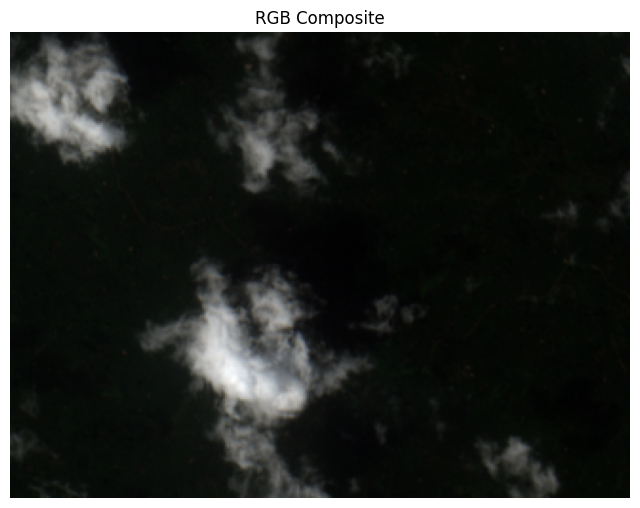

In [38]:
## Plot RGB image (Red: band 3, Green: band 2, Blue: band 1)
plot_rgb_window(test_tiffs[max_test_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

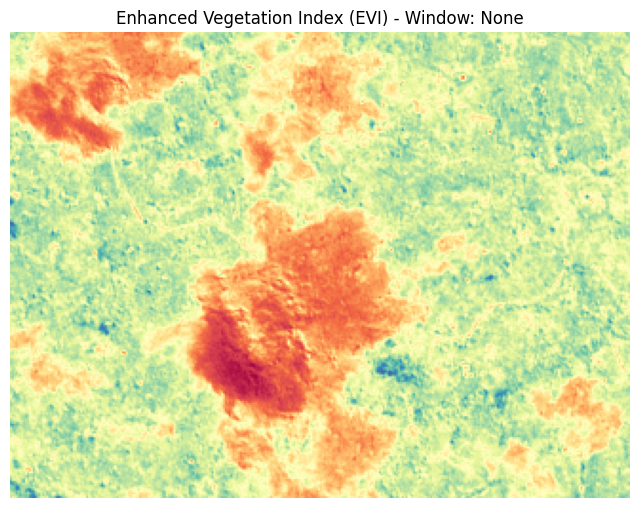

In [39]:
plot_evi(test_tiffs[max_test_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

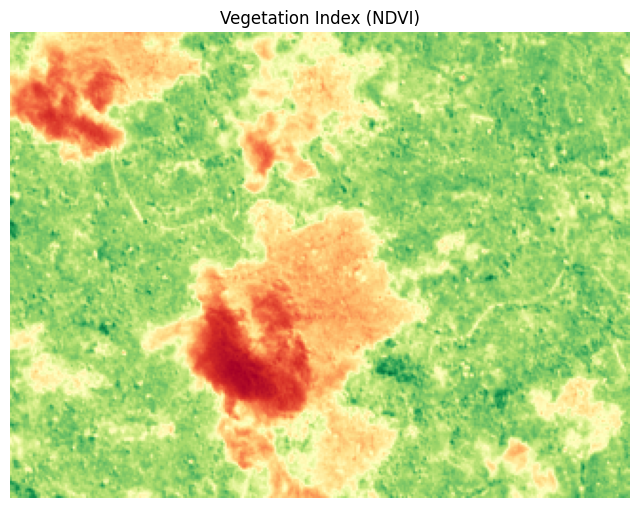

In [40]:
plot_vegetation_index(test_tiffs[max_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

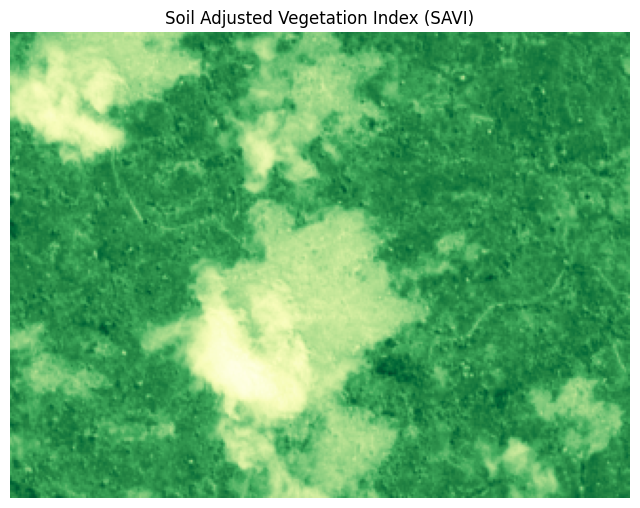

In [41]:
plot_savi(test_tiffs[max_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

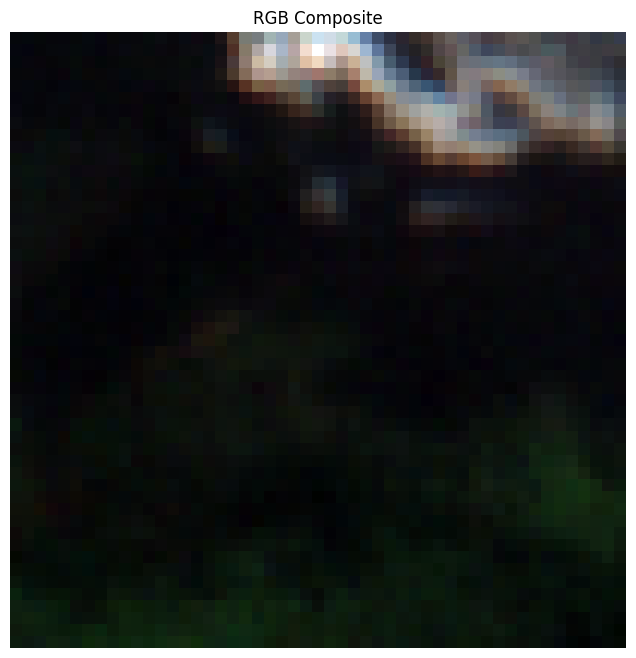

In [42]:
## Plot RGB image (Red: band 3, Green: band 2, Blue: band 1)
plot_rgb_window(test_tiffs[min_test_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

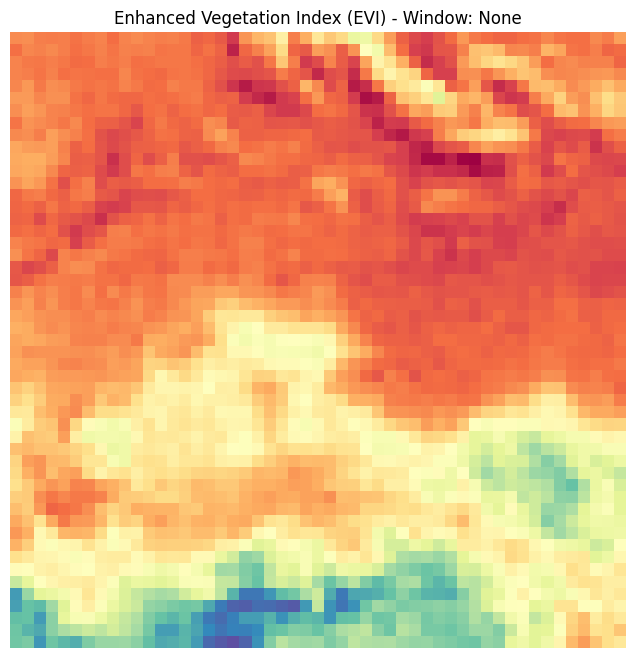

In [43]:
plot_evi(test_tiffs[min_test_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

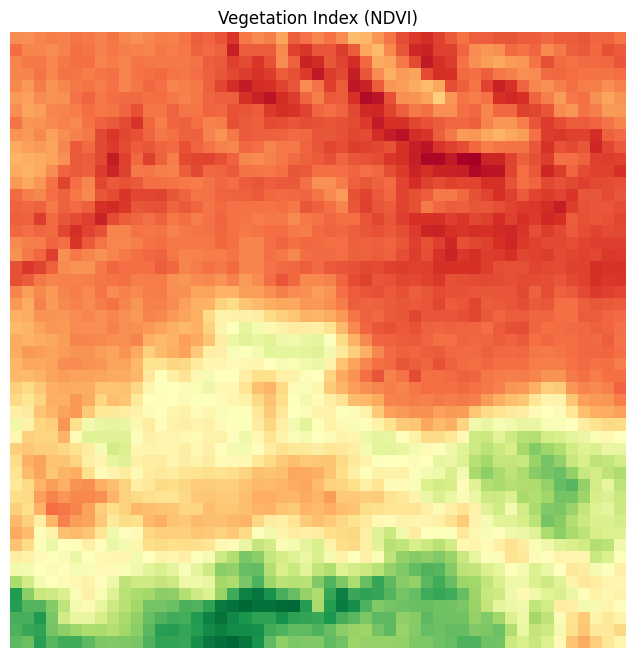

In [44]:
plot_vegetation_index(test_tiffs[min_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

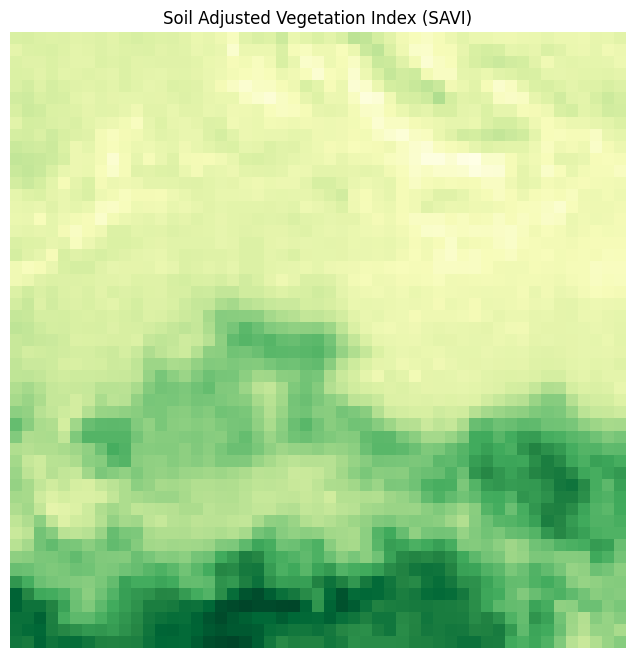

In [45]:
plot_savi(test_tiffs[min_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

## Pipeline for Crop Classification

These functions are used for building a basic machine learning model and displaying the target distribution.

In [46]:
import os
import rasterio
import numpy as np
import pandas as pd
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score

TILE_SIZE = MAX_TILE_SIZE

def extract_ndvi(nir_band, red_band, epsilon=1e-8):
    """ Calculate NDVI from NIR and Red bands """
    return (nir_band - red_band) / (nir_band + red_band + epsilon)

def extract_savi(nir_band, red_band, L=0.5):
    """ Calculate SAVI from NIR and Red bands """
    return ((nir_band - red_band) * (1 + L)) / (nir_band + red_band + L)

def extract_evi(nir_band, red_band, blue_band, G=2.5, C1=6, C2=7.5, L=10000):
    """ Calculate EVI from NIR, Red, and Blue bands """
    return G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))


def process_and_return_tiles(df, is_train=True, tile_size=TILE_SIZE):
    all_tiles = []
    all_labels = []

    for _, row in df.iterrows():
        tile_path = row['tifPath']

        if is_train:
            label_vector = [row['Target']]
        else:
            label_vector = None

        if tile_path and os.path.exists(tile_path):
            try:
                with rasterio.open(tile_path) as src:
                    raster = src.read()  # (bands, height, width)

                # Optional: pad if smaller than tile_size
                bands, height, width = raster.shape
                padded = np.zeros((bands, tile_size, tile_size))
                padded[:, :height, :width] = raster

                all_tiles.append(padded)

                if is_train:
                    all_labels.append(label_vector)  # Append as a single list, not extend

            except Exception as e:
                print(f"⚠️ Failed to process {tile_path}: {e}")
                continue

    all_tiles_array = np.stack(all_tiles)  # shape: (N, C, H, W)
    all_labels_array = np.array(all_labels) if is_train else None  # shape: (N, 3)

    return all_tiles_array, all_labels_array




def extract_features_from_tiles(tiles):
    """Extract statistical features (mean, median, std, min, max) from each band and index in a tile."""
    features = []

    for tile in tiles:
        # Assuming band order: B2 (Blue), B3 (Green), B4 (Red), B8 (NIR), B11, B12
        # band_sel = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        blue = tile[1]
        green = tile[2]
        red = tile[3]
        nir = tile[7]
        b11 = tile[10]
        b12 = tile[11]

        # Compute indices
        ndvi = extract_ndvi(nir, red)
        savi = extract_savi(nir, red)
        evi = extract_evi(nir, red, blue)

        # Function to get basic stats
        def stats(arr):
            return [
                np.nanmean(arr),
                np.nanmedian(arr),
                np.nanstd(arr),
                np.nanmin(arr),
                np.nanmax(arr)
            ]

        # Feature vector
        feature_vector = (
            stats(blue) + stats(green) + stats(red) +
            stats(nir) + stats(b11) + stats(b12) +
            stats(ndvi) + stats(savi) + stats(evi)
        )

        features.append(feature_vector)

    # Column names
    stat_names = ['mean', 'median', 'std', 'min', 'max']
    bands = ['B2_Blue', 'B3_Green', 'B4_Red', 'B8_NIR', 'B11', 'B12', 'NDVI', 'SAVI', 'EVI']
    columns = [f"{band}_{stat}" for band in bands for stat in stat_names]

    return pd.DataFrame(features, columns=columns)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import numpy as np
import pandas as pd

def train_classifier(X_train, y_train):
    """Train Random Forest Classifier."""
    # Convert one-hot to integer labels
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier_multi(clf, X_test, y_test):
    """Evaluate the classifier."""
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    y_pred = clf.predict(X_test)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Optional: class-level accuracy
    class_labels = np.unique(y_test)
    for cls in class_labels:
        cls_acc = np.mean(y_pred[y_test == cls] == cls)
        print(f"Accuracy for class {cls}: {cls_acc:.2f}")


def evaluate_classifier(clf, X_test, y_test):
    """Evaluate the classifier on multi-class single-label targets (non-binary encoded)."""

    # Flatten if y_test is nested like [['Cocoa'], ['Palm'], ...]
    y_test = np.ravel(y_test)

    # Predict
    y_pred = clf.predict(X_test)

    # Flatten prediction as well (if needed)
    y_pred = np.ravel(y_pred)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Class-level accuracy
    class_labels = np.unique(y_test)
    for cls in class_labels:
        cls_acc = np.mean(y_pred[y_test == cls] == cls)
        print(f"Accuracy for class '{cls}': {cls_acc:.2f}")



def plot_class_distribution(y):
    """Plot distribution of crop types from string class names with custom color mapping."""

    # Flatten the nested list/array
    y_flat = np.array(y).flatten()

    # Map crop names to numeric values
    class_map = {'Cocoa': 1, 'Palm': 2, 'Rubber': 3}
    reverse_map = {1: 'Cocoa', 2: 'Palm', 3: 'Rubber'}
    color_map = {'Cocoa': 'brown', 'Palm': 'green', 'Rubber': 'darkgray'}

    # Convert class names to numeric labels
    y_numeric = [class_map.get(label) for label in y_flat if label in class_map]

    # Convert back to names for counting and plotting
    y_named = [reverse_map[label] for label in y_numeric]

    # Create distribution dataframe
    crop_distribution = pd.Series(y_named).value_counts().reset_index()
    crop_distribution.columns = ['Target', 'Count']

    # Plot using Plotly
    fig = px.bar(
        crop_distribution,
        x='Target',
        y='Count',
        title="Crop Distribution",
        color='Target',
        color_discrete_map=color_map
    )

    fig.show()


## Toy example - only deal with a single month

I am handling the fact that images are not found some month. Users will have to figure how to effectively deal with this issue, since the model should not be limited to a single point in time.

In [48]:
train_jan = train[train['month'] == 'Jan']
train_jan.head()

ID  year month  \
0  ID_h14T0B_Jan  2024   Jan   
1  ID_KbyKOr_Jan  2024   Jan   
2  ID_t4Tmmn_Jan  2024   Jan   
3  ID_yipWoC_Jan  2024   Jan   
4  ID_XKiksa_Jan  2024   Jan   

                                             tifPath  Target  class  
0  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
1  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
2  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
3  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3  
4  /content/drive/MyDrive/train_s2_images_new_fin...  Rubber      3

In [49]:
# Any missing value in January ?
train_jan.isna().sum()

ID         0
year       0
month      0
tifPath    0
Target     0
class      0
dtype: int64

In [50]:
test_jan = test[test['month'] == 'Jan']
test_jan.head()

ID  year month  \
0  ID_731818_Jan  2024   Jan   
1  ID_790093_Jan  2024   Jan   
2  ID_931033_Jan  2024   Jan   
3  ID_079024_Jan  2024   Jan   
4  ID_691532_Jan  2024   Jan   

                                             tifPath  
0  /content/drive/MyDrive/test_s2_images_new_fina...  
1  /content/drive/MyDrive/test_s2_images_new_fina...  
2  /content/drive/MyDrive/test_s2_images_new_fina...  
3  /content/drive/MyDrive/test_s2_images_new_fina...  
4  /content/drive/MyDrive/test_s2_images_new_fina...

In [51]:
# Any missing images in January ?
test_jan.isna().sum()

ID         0
year       0
month      0
tifPath    0
dtype: int64

In [52]:
# MAIN PIPELINE

# 1. Process the raster
tiles_array, labels = process_and_return_tiles(train_jan)
print(f"The shape of tiles_array is: {tiles_array.shape}")
print(f"The length of labels is: {len(labels)}")

The shape of tiles_array is: (953, 12, 326, 326)
The length of labels is: 953


In [53]:
# 2. Extract features from tiles (pixel values, NDVI, SAVI, and EVI)
X = extract_features_from_tiles(tiles_array)

y = np.array(labels)

In [54]:
tiles_array[0].shape

(12, 326, 326)

In [55]:
X.shape, y.shape

((953, 45), (953, 1))

In [56]:
X.head()

B2_Blue_mean  B2_Blue_median  B2_Blue_std  B2_Blue_min  B2_Blue_max  \
0     55.503660             0.0   350.427713          0.0       2401.0   
1     55.044272             0.0   347.536140          0.0       2330.0   
2     56.144868             0.0   350.977439          0.0       2366.0   
3     55.729779             0.0   351.884841          0.0       2638.0   
4     58.678686             0.0   374.832781          0.0       4106.0   

   B3_Green_mean  B3_Green_median  B3_Green_std  B3_Green_min  B3_Green_max  \
0      51.340538              0.0    324.154823           0.0        2248.0   
1      51.483693              0.0    325.098002           0.0        2217.0   
2      52.885713              0.0    330.658430           0.0        2293.0   
3      52.505091              0.0    331.549085           0.0        2529.0   
4      54.894633              0.0    352.291988           0.0        4142.0   

   ...  SAVI_mean  SAVI_median  SAVI_std  SAVI_min  SAVI_max  EVI_mean  \
0  ...   0.011470          0.0  0.072709       0.0  0.590861  0.013618   
1  ...   0.011372          0.0  0.071988       0.0  0.571825  0.013101   
2  ...   0.011381          0.0  0.071956       0.0  0.646855  0.012963   
3  ...   0.011382          0.0  0.072141       0.0  0.629361  0.013250   
4  ...   0.009008          0.0  0.058165       0.0  0.587102  0.010576   

   EVI_median   EVI_std  EVI_min   EVI_max  
0         0.0  0.086467      0.0  0.739630  
1         0.0  0.083041      0.0  0.702232  
2         0.0  0.082360      0.0  0.797287  
3         0.0  0.084123      0.0  0.769892  
4         0.0  0.068319      0.0  0.723949  

[5 rows x 45 columns]

In [57]:
# Show the distribution of the Target (class)
plot_class_distribution(y)

In [58]:
from sklearn.model_selection import train_test_split

# Split into train/test
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [59]:
# Show the distribution of the Target (class)
plot_class_distribution(y_train)

In [60]:
# Show the distribution of the Target (class)
plot_class_distribution(y_eval)

In [61]:
# 3. Train the classifier
clf = train_classifier(X_train, y_train)

# 4. Evaluate the classifier (Humm! - This is still part of the train dataset!)
evaluate_classifier(clf, X_eval, y_eval)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Classification Report:
              precision    recall  f1-score   support

       Cocoa       0.96      0.94      0.95        47
        Palm       0.84      0.78      0.81        63
      Rubber       0.86      0.93      0.89        81

    accuracy                           0.88       191
   macro avg       0.89      0.88      0.88       191
weighted avg       0.88      0.88      0.88       191

Overall Accuracy: 0.88
Accuracy for class 'Cocoa': 0.94
Accuracy for class 'Palm': 0.78
Accuracy for class 'Rubber': 0.93


In [62]:
#5. Generate a df for test (expect labels_test to be None)
tiles_test, labels_test = process_and_return_tiles(test_jan, is_train=False)

print(f"The shape of tiles_array is: {tiles_test.shape}")
print(f"The test labels is: {labels_test}")

X_test = extract_features_from_tiles(tiles_test)

X_test.head()

The shape of tiles_array is: (282, 12, 326, 326)
The test labels is: None


B2_Blue_mean  B2_Blue_median  B2_Blue_std  B2_Blue_min  B2_Blue_max  \
0     68.349100             0.0   446.629630          0.0       4364.0   
1     56.528219             0.0   357.382065          0.0       3166.0   
2     57.772677             0.0   369.003486          0.0       3704.0   
3     55.504742             0.0   350.524921          0.0       2655.0   
4     54.184557             0.0   342.170773          0.0       2688.0   

   B3_Green_mean  B3_Green_median  B3_Green_std  B3_Green_min  B3_Green_max  \
0      65.682562              0.0    432.806570           0.0        4453.0   
1      51.643485              0.0    326.716401           0.0        3052.0   
2      54.937192              0.0    352.138266           0.0        3691.0   
3      51.170584              0.0    323.248413           0.0        2537.0   
4      50.061406              0.0    316.226987           0.0        2637.0   

   ...  SAVI_mean  SAVI_median  SAVI_std  SAVI_min  SAVI_max  EVI_mean  \
0  ...   0.007486          0.0  0.050936       0.0  0.555810  0.009407   
1  ...   0.007509          0.0  0.049674       0.0  0.600934  0.008774   
2  ...   0.011033          0.0  0.071060       0.0  0.622217  0.012644   
3  ...   0.008570          0.0  0.055302       0.0  0.554952  0.009768   
4  ...   0.009500          0.0  0.060965       0.0  0.568740  0.010585   

   EVI_median   EVI_std  EVI_min   EVI_max  
0         0.0  0.063351      0.0  0.698756  
1         0.0  0.058454      0.0  0.761134  
2         0.0  0.081066      0.0  0.731686  
3         0.0  0.063275      0.0  0.665014  
4         0.0  0.068193      0.0  0.673433  

[5 rows x 45 columns]

In [63]:
#6. Predict for test
y_pred = clf.predict(X_test)

In [65]:
## Prep submission file
sampleSub = pd.read_csv("SampleSubmission.csv")

ss = sampleSub[['ID']].copy()
ss['Target'] = y_pred
ss.columns = ['ID', 'Target']
ss.head()

ID  Target
0  ID_731818    Palm
1  ID_790093  Rubber
2  ID_931033  Rubber
3  ID_079024  Rubber
4  ID_691532  Rubber

In [66]:
plot_class_distribution(y_pred) ## Distribution of prediction

In [67]:
ss.head()

ID  Target
0  ID_731818    Palm
1  ID_790093  Rubber
2  ID_931033  Rubber
3  ID_079024  Rubber
4  ID_691532  Rubber

In [68]:
## Write submission file
ss.to_csv('submission.csv', index=False)